In [1]:
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from exojax.spec.dit import xsmatrix, xsvector, set_ditgrid, npnc1D
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
# Setting wavenumber bins and loading HITRAN database
nus=np.linspace(1900.0,2300.0,350000,dtype=np.float64) 
#nus=np.linspace(2000.0,2100.0,80000,dtype=np.float64) 
#nus=np.linspace(1900.0,2300.0,80000,dtype=np.float64)
mdbCO=moldb.MdbHit('05_hit12.par',nus)

In [25]:
Mmol=28.010446441149536 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere.
qt=mdbCO.Qr_layer_HAPI([Tfix])[0]

In [26]:
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)
# thermal doppler sigma
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

Checking the range of doppler and Lorentz widths

In [27]:
sigmaD_grid=set_ditgrid(sigmaD,res=0.1)
gammaL_grid=set_ditgrid(gammaL,res=0.2)

#sigmaD_grid=set_ditgrid(sigmaD,res=1.)
#gammaL_grid=set_ditgrid(gammaL,res=1.)

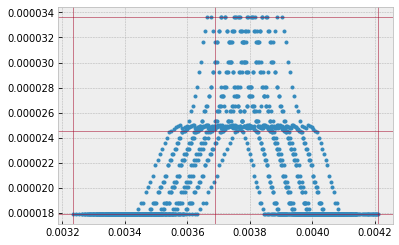

In [28]:
plt.plot(sigmaD,gammaL,".")
for i in sigmaD_grid:
    plt.axvline(i,lw=1,alpha=0.5,color="C1")
for i in gammaL_grid:
    plt.axhline(i,lw=1,alpha=0.5,color="C1")

In [33]:
#If you want to compute nu in JAX/GPU, be careful for the precision of wavenumber.
#reduce the digit 
from exojax.spec.dit import xsvector3D
dfnus=nus-np.median(nus)
dfnu_lines=mdbCO.nu_lines-np.median(nus)
xs3D=xsvector3D(dfnu_lines,sigmaD,gammaL,Sij,dfnus,sigmaD_grid,gammaL_grid)

In [32]:
#or precompute NCF for wavenumber
nu_ncf=npnc1D(mdbCO.nu_lines,nus)
xs=xsvector(nu_ncf,sigmaD,gammaL,Sij,nus,sigmaD_grid,gammaL_grid)

100%|██████████| 350000/350000 [00:05<00:00, 68173.94it/s]


In [29]:
#This may lead a large error
xs_bad=xsvector3D(mdbCO.nu_lines,sigmaD,gammaL,Sij,nus,sigmaD_grid,gammaL_grid)

In [30]:
xsv=xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30) 

100%|██████████| 63/63 [00:01<00:00, 44.92it/s] 


Text(0, 0.5, 'Difference (cm2)')

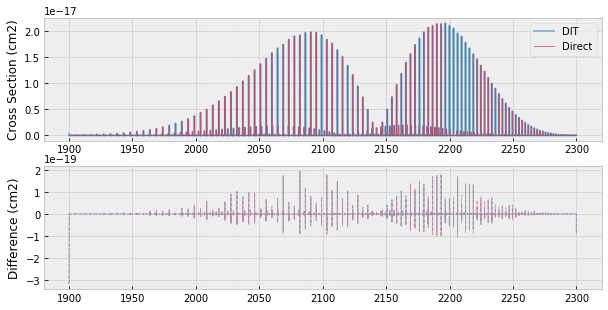

In [34]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=2,alpha=0.5,label="DIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=1,alpha=0.3)
plt.plot(nus,xsv-xs3D,lw=1,alpha=0.3,ls="dashed")
plt.ylabel("Difference (cm2)")
#plt.yscale("log")

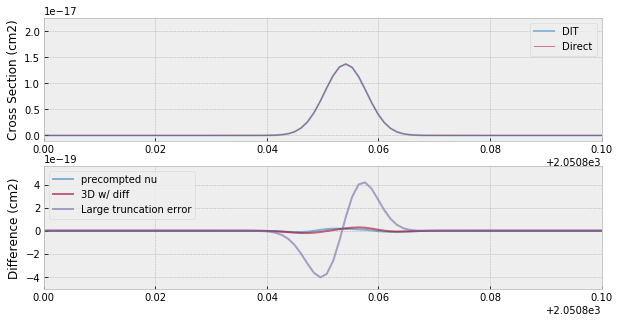

In [40]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=2,alpha=0.5,label="DIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct")
plt.legend(loc="upper right")
plt.xlim(2050.8,2050.9)
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.6,label="precompted nu")
plt.plot(nus,xsv-xs3D,lw=2,alpha=0.6,label="3D w/ diff")
plt.plot(nus,xsv-xs_bad,lw=2,alpha=0.6,label="Large truncation error")
plt.legend(loc="upper left")
plt.ylabel("Difference (cm2)")
plt.xlim(2050.8,2050.9)
#plt.yscale("log")
plt.savefig("fine_grid.png")